# Targeted Analysis (2k Samples)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scripts.text_operations import (
    clean_data,
    encode_text
)
from scripts.clustering import create_clusters

# SKLearn imports
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation

# Scipy import
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cityblock
from scipy.spatial.distance import mahalanobis

W0518 06:34:36.404087 140545725142784 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
[nltk_data] Downloading package stopwords to /home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load Data and Cluster

In [2]:
%run ../../api/classy990downloads.ipynb


year = 2017
uri='mongodb://mongo/irs990'

db = mongo990( uri=uri, year=year, dump=False)
        
db.verify()


importing Jupyter notebook from /home/notebooks/api/filter_text.ipynb
importing Jupyter notebook from /home/notebooks/api/ParseWeb.ipynb


[nltk_data] Downloading package wordnet to /home/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Connect to: [mongodb://mongo/irs990]
List of databases in MongoDB: ['admin', 'config', 'irs990', 'local']
Open db: [irs990]
Collection: [2017]
1418 documents present
1418 documents present


In [3]:
fields = {
    "/IRS990/ActivityOrMissionDesc":1,
    '/IRS990/Desc':1,
    'EIN':1,
    '/IRS990/MissionDesc':1,
    'OrganizationName':1,
    'WebSnippet':1,
    '/IRS990/WebsiteAddressTxt':1,
}

col_names = [
            'ActivityOrMissionDesc',
            'Desc',
            'MissionDesc',
            'WebsiteAddressTxt',
            'EIN',
            'OrganizationName',
            '_id'
        ]


In [4]:
#col_names = [
#    "ActivityOrMissionDesc", 'BooksInCareOfDetail/USAddress/ZIPCode','CYSalariesCompEmpBnftPaidAmt',
#    'CYTotalExpensesAmt','CYTotalProfFndrsngExpnsAmt','CYTotalRevenueAmt','Desc','EIN','EmployeeCnt',
#    'FormType','GovernmentGrantsAmt', 'GrossReceiptsAmt','MissionDesc', 'NetAssetsOrFundBalancesEOYAmt',
#    'OrganizationName','OtherSalariesAndWagesGrp/TotalAmt','PYSalariesCompEmpBnftPaidAmt','PYTotalExpensesAmt',
#    'PYTotalProfFndrsngExpnsAmt','PYTotalRevenueAmt','RelatedOrganizationsAmt','RevenueAmt','TaxExemptBondsInd',
#    'TaxPeriod','TotalAssetsGrp/EOYAmt','TotalContributionsAmt', 'TotalEmployeeCnt','TotalLiabilitiesGrp/EOYAmt',
#    'TotalNetAssetsFundBalanceGrp/EOYAmt','TotalVolunteersCnt','URL','WebsiteAddressTxt','_id'
#]

In [5]:
data = pd.DataFrame(list(db.collection.find( {}, fields  )))

In [6]:
data.columns= col_names
data.dropna(subset=['WebsiteAddressTxt','ActivityOrMissionDesc','Desc','MissionDesc'],inplace=True)  
#data =  data[data['MissionDesc'] != 'N/A']
#data.dropna(inplace=True)

In [7]:
#data = pd.read_csv('sample_2000_M5.csv')

In [8]:
data.head()

,ActivityOrMissionDesc,Desc,MissionDesc,WebsiteAddressTxt,EIN,OrganizationName,_id
0,see,operation lodge charitable recreational enjoym...,see,N/A,042662873,ELKS BUILDING CORP OF NORWOOD,042662873_201603
1,develop affordable rental ownership housing in...,community service work community member east b...,see page line,"[https://noahcdc.org, https://noahcdc.org/?q=a...",042964630,NEIGHBORHOOD OF AFFORDABLE HOUSING INC,042964630_201512
2,releaf michigan inc assist community urban pla...,tree seedling planted cooperation community or...,releaf michigan inc assist community urban pla...,RELEAFMICHIGAN.ORG,382912028,RELEAF MICHIGAN INC,382912028_201512
4,support family friend mentally ill lost loved ...,support group family friend mentally ill met t...,support family friend mentally ill lost loved ...,WWW.KARLASMITHFOUNDATION.ORG,202699020,KARLA SMITH FOUNDATION,202699020_201512
5,creation revolving loan fund,creation revolving loan fund low interest loan...,assist regional economic recovery strategy aid...,www.developerie.com,251525572,ENTERPRISE DEVELOPMENT FUND OF ERIE COUNTY INC,251525572_201512


In [9]:
# Clean text data
clean_df = clean_data(data)

# Get text encodings
encoding_dict = encode_text(clean_df)

Instructions for updating:
Colocations handled automatically by placer.


W0518 06:34:44.031349 140545725142784 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0518 06:34:45.539750 140545725142784 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Graph was finalized.


I0518 06:34:45.821033 140545725142784 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0518 06:35:02.294925 140545725142784 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0518 06:35:15.349582 140545725142784 session_manager.py:493] Done running local_init_op.


In [10]:
clean_df.head()

,EIN,Name,Text
0,042662873,ELKS BUILDING CORP OF NORWOOD,elk building corp norwood operation lodge char...
1,042964630,NEIGHBORHOOD OF AFFORDABLE HOUSING INC,neighborhood affordable housing inc community ...
2,382912028,RELEAF MICHIGAN INC,releaf michigan inc tree seedling planted coop...
3,202699020,KARLA SMITH FOUNDATION,karla smith foundation support group family fr...
4,251525572,ENTERPRISE DEVELOPMENT FUND OF ERIE COUNTY INC,enterprise development fund erie county inc cr...


In [11]:
# Assemble text encodings
X = np.array([encoding_dict[r['EIN']] for _, r in clean_df.iterrows()])
print(X.shape)

(521, 512)


In [12]:
# Dimensionality reduction (clustering)
pca_dimr = PCA(n_components=200)
X_dimr = pca_dimr.fit_transform(X)
expvar_1 = sum(pca_dimr.explained_variance_ratio_)

# Dimensionality reduction (t-SNE)
pca_tsne = PCA(n_components=70).fit(X)
X_tsne = pca_tsne.fit_transform(X)
expvar_2 = sum(pca_tsne.explained_variance_ratio_)

print('Explained variance (clustering): %.4f'%expvar_1)
print('Explained variance (t-SNE): %.4f'%expvar_2)

Explained variance (clustering): 0.9736
Explained variance (t-SNE): 0.8710


In [13]:
# Get cluster results
Z, gap_metrics, bc, clusters = create_clusters(X_dimr, C=70)

Scanning: 10
Scanning: 20
Scanning: 30
Scanning: 40
Scanning: 50
Scanning: 60
Scanning: 70

Cluster sizes: [18 20 22 25 26 27 29 30 32 33 35 38 39 40 41 42 43 44 46 48 49 50 51 52
 53 54 55 56 57 58 60 62 63 64 65 66 67 68 69]


In [14]:
# Update clean df
clean_df['cluster'] = clusters

## Interpret Results

### t-SNE Visualization

In [15]:
# Get t-SNE embedding
X_temb = TSNE(
    n_components=2, verbose=1, perplexity=40, n_iter=500
).fit_transform(X_tsne)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 521 samples in 0.033s...
[t-SNE] Computed neighbors for 521 samples in 0.068s...
[t-SNE] Computed conditional probabilities for sample 521 / 521
[t-SNE] Mean sigma: 0.291481
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.417145
[t-SNE] KL divergence after 500 iterations: 1.043129


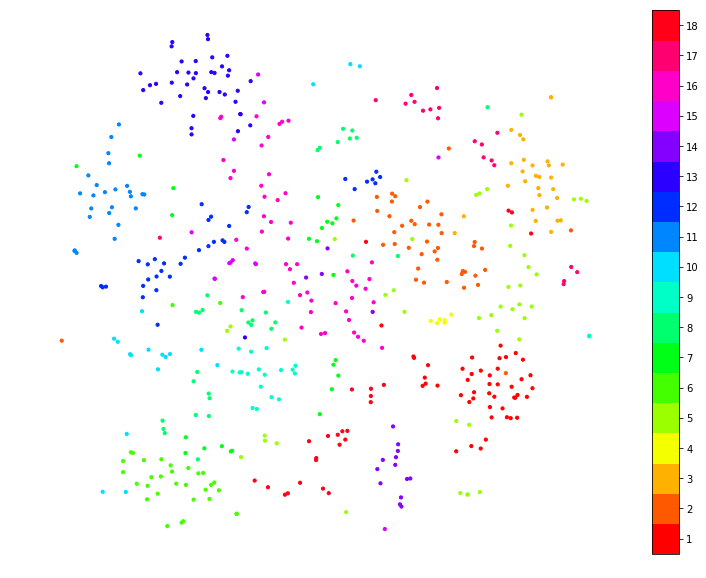

In [16]:
# Visualize t-SNE plot
vis_x = X_temb[:, 0]
vis_y = X_temb[:, 1]

plt.figure(figsize=(13, 10))
plt.axis('off')
plt.scatter(
    x=vis_x, 
    y=vis_y,
    s=10,
    c=clusters, 
    cmap=plt.cm.get_cmap('hsv', bc[0])
)
plt.colorbar(ticks=range(bc[0]+1))
plt.clim(0.5, bc[0]+0.5)
plt.show()

### Global LDA Verification

In [17]:
#------------------------------------------------------------------------------#
# Global LDA verification functions
#------------------------------------------------------------------------------#
def display_topics(model, feature_names, no_top_words):
    """
    Helper function for displaying top words of a topic
    """
    for topic_idx, topic in enumerate(model.components_):
        print('\nTopic %d:'%(topic_idx+1))
        print(' '.join([
            feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]
        ]))
    
    return None


def topic_distribution(df, X_lda, n_clusters, cluster_num):
    """
    Helper function for displaying distribution of LDA topics for a single 
    cluster
    """
    # Get indexes of topic selection
    select_df = df[df['cluster']==cluster_num].copy(deep=True)
    select_idx = select_df.index.values
    
    # Aggregate probabilties
    X_prob = X_lda[select_idx]
    print(select_idx)
    print()
    print(X_prob)
    X_max = np.max(X_prob)
    agg_probs = np.prod(X_prob/X_max, axis=0)
    
    # Plot probabilities
    fig, ax = plt.subplots(3, 1, figsize=(10, 21))
    ax[0].bar(
        x = np.arange(n_clusters)+1,
        height = agg_probs,
        width=0.6
    )
    ax[0].set_xticks(np.arange(1, n_clusters+1, 2))
    ax[0].set_title('LDA Topic Probabilities for Cluster %d'%cluster_num)
    ax[0].set_ylabel('Agg. Probability')
    ax[0].set_xlabel('LDA Topic Numbers')
    
    # Plot argmax distribution
    argmax = np.argmax(X_prob, axis=1)+1
    argmax_idx, argmax_cnt = np.unique(argmax, return_counts=True)
    
    x_axis = np.arange(n_clusters)+1
    y_axis = np.array([
        argmax_cnt[np.where(argmax_idx==n)[0]][0]
        if n in argmax_idx else 0
        for n in x_axis
    ])
    ax[1].bar(
        x = x_axis,
        height = y_axis,
        width=0.6
    )
    ax[1].set_xticks(np.arange(1, n_clusters+1, 2))
    ax[1].set_title('LDA Topic Counts for Cluster %d'%cluster_num)
    ax[1].set_ylabel('LDA Topic Counts')
    ax[1].set_xlabel('LDA Topic Numbers')
    
    # Probability density calculations
    prob_df = pd.DataFrame(
        data = X_prob,
        index = np.arange(len(select_idx)),
        columns = np.arange(n_clusters)
    )
    prob_df.plot.kde(legend=False, ax=ax[2])
    ax[2].set_title('Probability Density Plot for Cluster %d'%cluster_num)
    plt.show()
    
    return None
#------------------------------------------------------------------------------#

In [18]:
# Count-vectorize corpus
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
tf = tf_vectorizer.fit_transform(clean_df['Text'].values)
tf_feature_names = tf_vectorizer.get_feature_names()

In [19]:
# Run LDA
lda = LatentDirichletAllocation(
    n_components=bc[0], 
    max_iter=5,
    random_state=0
)
X_lda = lda.fit_transform(tf)

In [20]:
# Show top words of topics
display_topics(lda, tf_feature_names, 10)


Topic 1:
service provide animal development area program economic inc county coastal

Topic 2:
land association member florida school law officer student enforcement professional

Topic 3:
child care family support foundation home health community program quality

Topic 4:
research public government safety policy disease center information committee issue

Topic 5:
housing community income low nonprofit affordable provide elderly person foundation

Topic 6:
support program community conservation farmer people wildlife education public water

Topic 7:
state promote healthy michigan community leader program public support life

Topic 8:
worker social provide community organization educational individual economic student people

Topic 9:
education student public health provide charter national housing inc operating

Topic 10:
child family community county care foster resident inc organization mission

Topic 11:
program project public research new community city fund historic building

To

[  0   9  11  63  83 117 128 139 151 201 211 236 292 327 339 342 345 350
 355 400 430 434 435 438 484 520]

[[5.05050530e-03 2.42833974e-01 5.05050577e-03 6.76357934e-01
  5.05050567e-03 5.05050562e-03 5.05050580e-03 5.05050552e-03
  5.05050516e-03 5.05050557e-03 5.05050603e-03 5.05050655e-03
  5.05050552e-03 5.05050621e-03 5.05050608e-03 5.05050598e-03
  5.05050570e-03 5.05050552e-03]
 [1.63398709e-03 1.63398731e-03 1.63398714e-03 1.63398730e-03
  1.63398703e-03 1.63398702e-03 1.63398722e-03 1.63398723e-03
  1.63398717e-03 1.63398703e-03 1.63398715e-03 1.63398705e-03
  1.63398704e-03 1.63398845e-03 1.63398715e-03 9.72222217e-01
  1.63398713e-03 1.63398714e-03]
 [7.93650893e-04 7.93650893e-04 2.20468092e-01 7.93650920e-04
  7.93650891e-04 7.93650896e-04 7.93650864e-04 7.93650916e-04
  8.11678120e-02 7.93650880e-04 6.86459332e-01 7.93650920e-04
  7.93650921e-04 7.93650902e-04 7.93650880e-04 7.93650949e-04
  7.93650884e-04 7.93650930e-04]
 [4.27350478e-03 4.27350435e-03 4.27350450e-03 4.

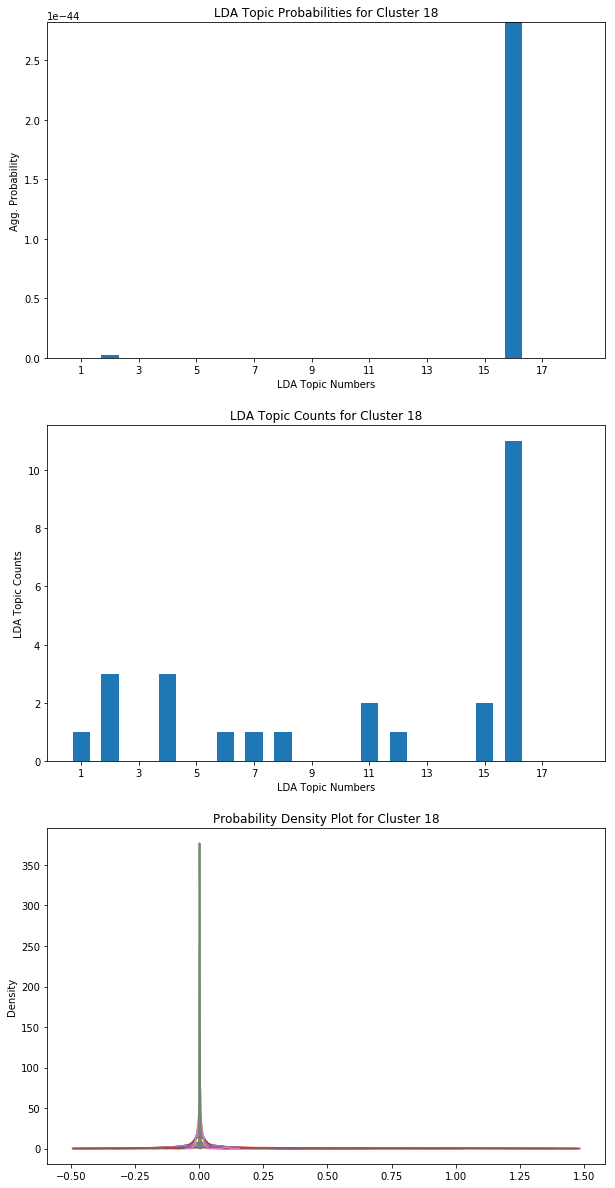

In [21]:
# Visualize topic distribution
topic_distribution(clean_df, X_lda, bc[0], len(clean_df.cluster.unique()))

In [22]:
# for i in range(1, bc[0]+1):
#     print('-'*40)
#     print('Cluster:', i)
#     print('-'*40)
#     topic_distribution(clean_df, X_lda, bc[0], i)

### Local LDA Verification

In [23]:
#------------------------------------------------------------------------------#
# Local LDA verification functions
#------------------------------------------------------------------------------#
def local_lda_transform(df, cluster_num):
    """
    Function for applying an LDA transformation to a local document cluster. LDA
    transforms documents into a 10-feature topic space.
    
    Input(s):
    - df (pandas dataframe)
    - cluster_num (int): cluster ID number
    """
    if cluster_num not in df['cluster'].values:
        raise ValueError('Invalid cluster ID')
    
    # Get text subset
    text_subset = df[df['cluster']==cluster_num]['Text'].values
    
    # Count-vectorize subset
    tf_params = {
        'max_df': 0.95,
        'min_df': 2,
        'max_features': 1000
    }
    tf = CountVectorizer(**tf_params)
    X_tf = tf.fit_transform(text_subset)
    
    # Run LDA
    lda_params = {
        'n_components': 10, # Default 10 components
        'max_iter': 5,
        'random_state': 0
    }
    lda = LatentDirichletAllocation(**lda_params)
    X_lda = lda.fit_transform(X_tf)
    
    return X_lda


def get_pairwise_distances(X_lda, dist_flag='euclidean'):
    """
    Function for constructing a pairwise distance matrix of sample points
    
    Input(s):
    - X_lda (numpy ndarray): lda-transformed cluster sample, shape (N, 10)
    - dist_flag (str): string flag for distance metric
    """
    X_lda = X_lda +0.00001*np.random.rand(X_lda.shape[0], 10)
    
    FLAGS = ['cosine', 'euclidean', 'cityblock', 'mahalanobis']
    if dist_flag not in FLAGS:
        raise ValueError('Invalid distance flag')
    
    # Number of samples
    N = X_lda.shape[0]
    
    # Calculate covariance matrix and invert
    icov = np.linalg.inv(np.cov(X_lda.T))
    
    # Instantiate pairwise placeholder
    pairwise = np.zeros((N, N))
    
    for i, sample1 in enumerate(X_lda):
        for j, sample2 in enumerate(X_lda):
            if dist_flag=='cosine':
                pairwise[i, j] = cosine(sample1, sample2)
            elif dist_flag=='euclidean':
                pairwise[i, j] = euclidean(sample1, sample2)
            elif dist_flag=='cityblock':
                pairwise[i, j] = cityblock(sample1, sample2)
            elif dist_flag=='mahalanobis':
                pairwise[i, j] = mahalanobis(sample1, sample2, icov)
    
    return pairwise


def get_local_pdf(x):
    """
    Function for calculating the PDF for a single-feature array
    
    Input(s):
    - x (numpy ndarray): single-feature array
    """
    # Define sample range with which PDF is evaluated
    sample_range = np.nanmax(x) - np.nanmin(x)
    ind = np.linspace(
        np.nanmin(x) - 0.5 * sample_range,
        np.nanmax(x) + 0.5 * sample_range, 
        1000) # 1000 points
    
    # Define gaussian kernel object and evaluate
    gkde = gaussian_kde(x)
    y = gkde.evaluate(ind)
    
    return ind, y


def num_local_max(pdf):
    """
    Function for calculating the number of local maxima, given an array of PDF
    values
    """
    threshold = np.max(pdf)/2
    
    peaks = find_peaks(pdf, height=threshold)
    p_idx = peaks[0]
    
    return len(p_idx)


def scan_local_cluster(pairwise):
    """
    Function for scanning through the LDA-transformed points of a local document
    cluster to evaluate the average number of PDF local maxima
    
    Input(s):
    - pairwise (numpy ndarray): calculated pairwise distances
    """
    num_maxes = np.ones(pairwise.shape[0])
    
    for i, row in enumerate(pairwise):
        ind, y = get_local_pdf(row)
        num_maxes[i] = num_local_max(y)
    
    return np.average(num_maxes), np.std(num_maxes)
#------------------------------------------------------------------------------#

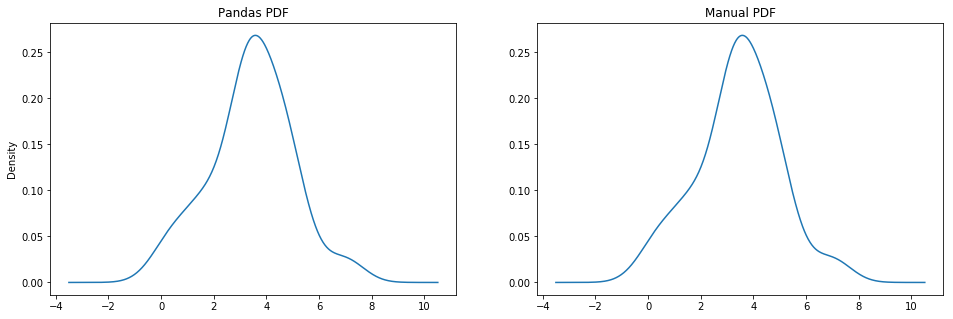

Number of local maxima: 1


In [24]:
# Sample demo
CLUSTER_IDX = 1
SAMPLE_IDX = 5

lda1 = local_lda_transform(clean_df, CLUSTER_IDX)
pair1 = get_pairwise_distances(lda1, 'mahalanobis')

# Manual PDF calculation
ind, y = get_local_pdf(pair1[SAMPLE_IDX])

# Demo dataframe
tmp_df = pd.DataFrame(data=pair1)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
tmp_df[SAMPLE_IDX].plot.kde(ax=ax[0])
ax[1].plot(ind, y)

ax[0].set_title('Pandas PDF')
ax[1].set_title('Manual PDF')

plt.show()

# Number of local maxima
print('Number of local maxima:', num_local_max(y))

In [25]:
# Run through clusters (note singular matrix := only 1 independent row)
for idx in np.sort(clean_df['cluster'].unique()):
    try:
        tmp_lda = local_lda_transform(clean_df, idx)
        tmp_pair = get_pairwise_distances(tmp_lda, 'euclidean')
        print('Cluster %02d: %.3f (AVG) / %.3f (STD)'%(idx, *scan_local_cluster(tmp_pair)))
    except np.linalg.LinAlgError:
        print('Cluster %02d: Singular Matrix'%idx)

Cluster 01: 1.044 (AVG) / 0.206 (STD)
Cluster 02: 1.000 (AVG) / 0.000 (STD)
Cluster 03: 1.000 (AVG) / 0.000 (STD)
Cluster 04: 1.667 (AVG) / 0.471 (STD)
Cluster 05: 1.000 (AVG) / 0.000 (STD)
Cluster 06: 1.000 (AVG) / 0.000 (STD)
Cluster 07: 1.000 (AVG) / 0.000 (STD)
Cluster 08: 1.000 (AVG) / 0.000 (STD)
Cluster 09: 1.000 (AVG) / 0.000 (STD)
Cluster 10: 1.000 (AVG) / 0.000 (STD)
Cluster 11: 1.000 (AVG) / 0.000 (STD)
Cluster 12: 1.000 (AVG) / 0.000 (STD)
Cluster 13: 1.000 (AVG) / 0.000 (STD)
Cluster 14: 1.000 (AVG) / 0.000 (STD)
Cluster 15: 1.000 (AVG) / 0.000 (STD)
Cluster 16: 1.385 (AVG) / 0.487 (STD)
Cluster 17: 1.000 (AVG) / 0.000 (STD)
Cluster 18: 1.000 (AVG) / 0.000 (STD)
